In [11]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [12]:
aggregated_data = pd.read_csv('chicago_preprocessed.csv')

In [20]:
# Define categorical and numerical columns
categorical_cols = ['Property Type', 'Listing Type', 'Neighborhood']
numerical_cols = [
    'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear', 'num_5_star_Rev_pastYear',
    'prop_5_StarReviews_pastYear', 'numReservedDays_pastYear', 'numReserv_pastYear',
    'available_days_aveListedPrice', 'booked_days_avePrice', 'Bedrooms', 'Bathrooms',
    'Max Guests', 'Cleaning Fee (USD)', 'Minimum Stay', 'Number of Photos', 'Nightly Rate',
    'Number of Reviews', 'Rating Overall', 'revenue', 'property_age_months'
]

# Exclude unnecessary columns
exclude_cols = ['Scraped Date', 'Airbnb Host ID', 'Airbnb Property ID', 'Created Date', 'available_days', 'booked_days']

# Preprocess the dataset
def preprocess_data(df, categorical_cols, numerical_cols, reference_columns=None):
    # Drop excluded columns
    df = df.drop(columns=exclude_cols, errors='ignore')
    # Convert categorical columns to dummy variables
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    # Standardize numerical columns
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    # Align columns with reference_columns (if provided)
    if reference_columns is not None:
        for col in reference_columns:
            if col not in df.columns:
                df[col] = 0
        df = df[reference_columns]
    return df

# Split the dataset
training_data = aggregated_data[aggregated_data['superhost_period_all'] <= 18]
testing_data = aggregated_data[aggregated_data['superhost_period_all'] == 19]
prediction_data = aggregated_data[aggregated_data['superhost_period_all'] == 20]

# Preprocess train, test, and prediction sets
X_train = preprocess_data(training_data.drop(['occupancy_rate'], axis=1), categorical_cols, numerical_cols)
y_train = training_data['occupancy_rate']

X_test = preprocess_data(testing_data.drop(['occupancy_rate'], axis=1), categorical_cols, numerical_cols, X_train.columns)
y_test = testing_data['occupancy_rate']

X_pred = preprocess_data(prediction_data.drop(['occupancy_rate'], axis=1), categorical_cols, numerical_cols, X_train.columns)

# Linear Regression Model
print("Training Linear Regression Model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_test_pred_lr = lr_model.predict(X_test)
mape_lr = mean_absolute_percentage_error(y_test, y_test_pred_lr)
print(f"Linear Regression MAPE: {mape_lr:.4f}")

# Gradient Boosting Model
print("Training Gradient Boosting Model...")
gb_model = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}
gb_grid = GridSearchCV(gb_model, param_grid, scoring='neg_mean_absolute_percentage_error', cv=3, verbose=1, n_jobs=-1)
gb_grid.fit(X_train, y_train)
best_gb_model = gb_grid.best_estimator_
y_test_pred_gb = best_gb_model.predict(X_test)
mape_gb = mean_absolute_percentage_error(y_test, y_test_pred_gb)
print(f"Gradient Boosting MAPE: {mape_gb:.4f}")

# Compare Models
print(f"\nMAPE Comparison:\nLinear Regression: {mape_lr:.4f}\nGuradient Boosting: {mape_gb:.4f}")

# Choose Best Model
best_model = lr_model if mape_lr < mape_gb else best_gb_model
y_pred = best_model.predict(X_pred)

# Save Predictions for Period 20
prediction_data['Predicted Occupancy Rate'] = y_pred
print("Predictions for Period 20:")
print(prediction_data[['Airbnb Host ID', 'Airbnb Property ID', 'Predicted Occupancy Rate']])

Training Linear Regression Model...
Linear Regression MAPE: 3.4110
Training Gradient Boosting Model...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Gradient Boosting MAPE: 2.4849

MAPE Comparison:
Linear Regression: 3.4110
Guradient Boosting: 2.4849
Predictions for Period 20:
       Airbnb Host ID  Airbnb Property ID  Predicted Occupancy Rate
15             2613.0              2384.0                  0.261089
31             5775.0              4505.0                  0.129550
58            17928.0              7126.0                  0.213822
73            33004.0              9811.0                  0.214108
89            33004.0             10945.0                  0.260924
...               ...                 ...                       ...
72122     289257440.0          42714699.0                  0.352340
72123     273627718.0          42746404.0                  0.164245
72124     336396789.0          42776417.0                  0.105214
72125      44131859.0      

/var/folders/66/kjdgfk_530v31znwf93fdr6h0000gn/T/ipykernel_62980/101141898.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_data['Predicted Occupancy Rate'] = y_pred



Feature Importance for Gradient Boosting Regressor:
Top 20 Features Based on Gradient Boosting Regressor:
                           Feature  Importance
25                        revenue    0.523157
13           booked_days_avePrice    0.239838
12  available_days_aveListedPrice    0.031138
17             Cleaning Fee (USD)    0.022952
92      Listing Type_Private room    0.020398
0            superhost_period_all    0.017975
22                   Nightly Rate    0.017844
6             numReviews_pastYear    0.016262
5             rating_ave_pastYear    0.013576
19               Number of Photos    0.012480
10       numReservedDays_pastYear    0.011431
16                     Max Guests    0.009787
11             numReserv_pastYear    0.006861
23              Number of Reviews    0.006184
26            property_age_months    0.003488
93       Listing Type_Shared room    0.003229
8         num_5_star_Rev_pastYear    0.002630
14                       Bedrooms    0.002136
9     prop_5_StarR

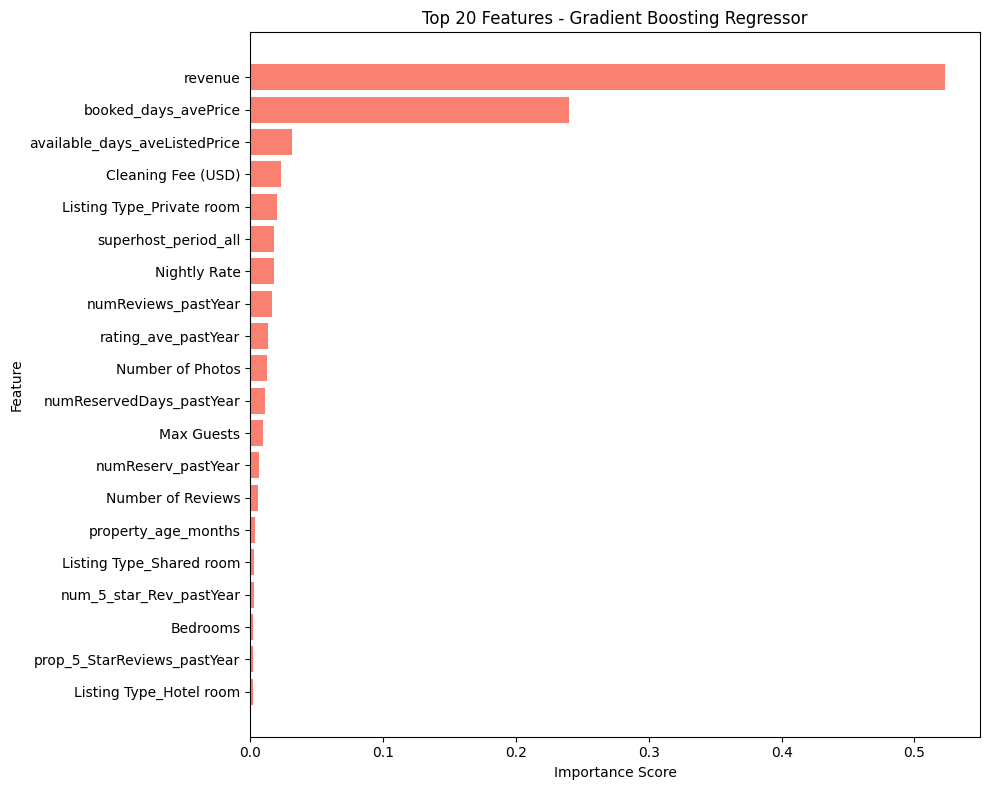

In [21]:
# Feature importance for Gradient Boosting Regressor
print("\nFeature Importance for Gradient Boosting Regressor:")
gb_feature_importances = best_gb_model.feature_importances_
feature_names = list(X_train.columns)
gb_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gb_feature_importances
}).sort_values(by='Importance', ascending=False)

# Display top 20 features
top_20_gb_features = gb_feature_importance_df.head(20)
print("Top 20 Features Based on Gradient Boosting Regressor:\n", top_20_gb_features)

# Plot top 20 features
plt.figure(figsize=(10, 8))
plt.barh(top_20_gb_features['Feature'], top_20_gb_features['Importance'], color='salmon')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 20 Features - Gradient Boosting Regressor')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()